In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelBinarizer, RobustScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import RandomizedSearchCV


In [2]:
data = pd.read_csv("/Users/mehrac/Desktop/DSA-Python/nasa.csv")
df = data.copy()

In [3]:
df.head()


,Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),...,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Equinox,Hazardous
0,3703080,3703080,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,...,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,J2000,True
1,3723955,3723955,21.3,0.146068,0.326618,146.067964,326.617897,0.090762,0.202951,479.225620,...,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,J2000,False
2,2446862,2446862,20.3,0.231502,0.517654,231.502122,517.654482,0.143849,0.321655,759.521423,...,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,J2000,True
3,3092506,3092506,27.4,0.008801,0.019681,8.801465,19.680675,0.005469,0.012229,28.876199,...,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,J2000,False
4,3514799,3514799,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,...,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,J2000,True


In [6]:
df.isnull().sum().sum()


0

In [7]:
df.duplicated().sum()


0

In [4]:
df.columns

Index(['Neo Reference ID', 'Name', 'Absolute Magnitude', 'Est Dia in KM(min)',
       'Est Dia in KM(max)', 'Est Dia in M(min)', 'Est Dia in M(max)',
       'Est Dia in Miles(min)', 'Est Dia in Miles(max)',
       'Est Dia in Feet(min)', 'Est Dia in Feet(max)', 'Close Approach Date',
       'Epoch Date Close Approach', 'Relative Velocity km per sec',
       'Relative Velocity km per hr', 'Miles per hour',
       'Miss Dist.(Astronomical)', 'Miss Dist.(lunar)',
       'Miss Dist.(kilometers)', 'Miss Dist.(miles)', 'Orbiting Body',
       'Orbit ID', 'Orbit Determination Date', 'Orbit Uncertainity',
       'Minimum Orbit Intersection', 'Jupiter Tisserand Invariant',
       'Epoch Osculation', 'Eccentricity', 'Semi Major Axis', 'Inclination',
       'Asc Node Longitude', 'Orbital Period', 'Perihelion Distance',
       'Perihelion Arg', 'Aphelion Dist', 'Perihelion Time', 'Mean Anomaly',
       'Mean Motion', 'Equinox', 'Hazardous'],
      dtype='object')

In [10]:
df.drop(['Close Approach Date'], axis=1, inplace=True)
df.drop(['Orbiting Body'], axis=1, inplace=True)
df.drop(["Orbit Determination Date"], axis=1, inplace=True)
df.drop(["Equinox"], axis=1, inplace=True)



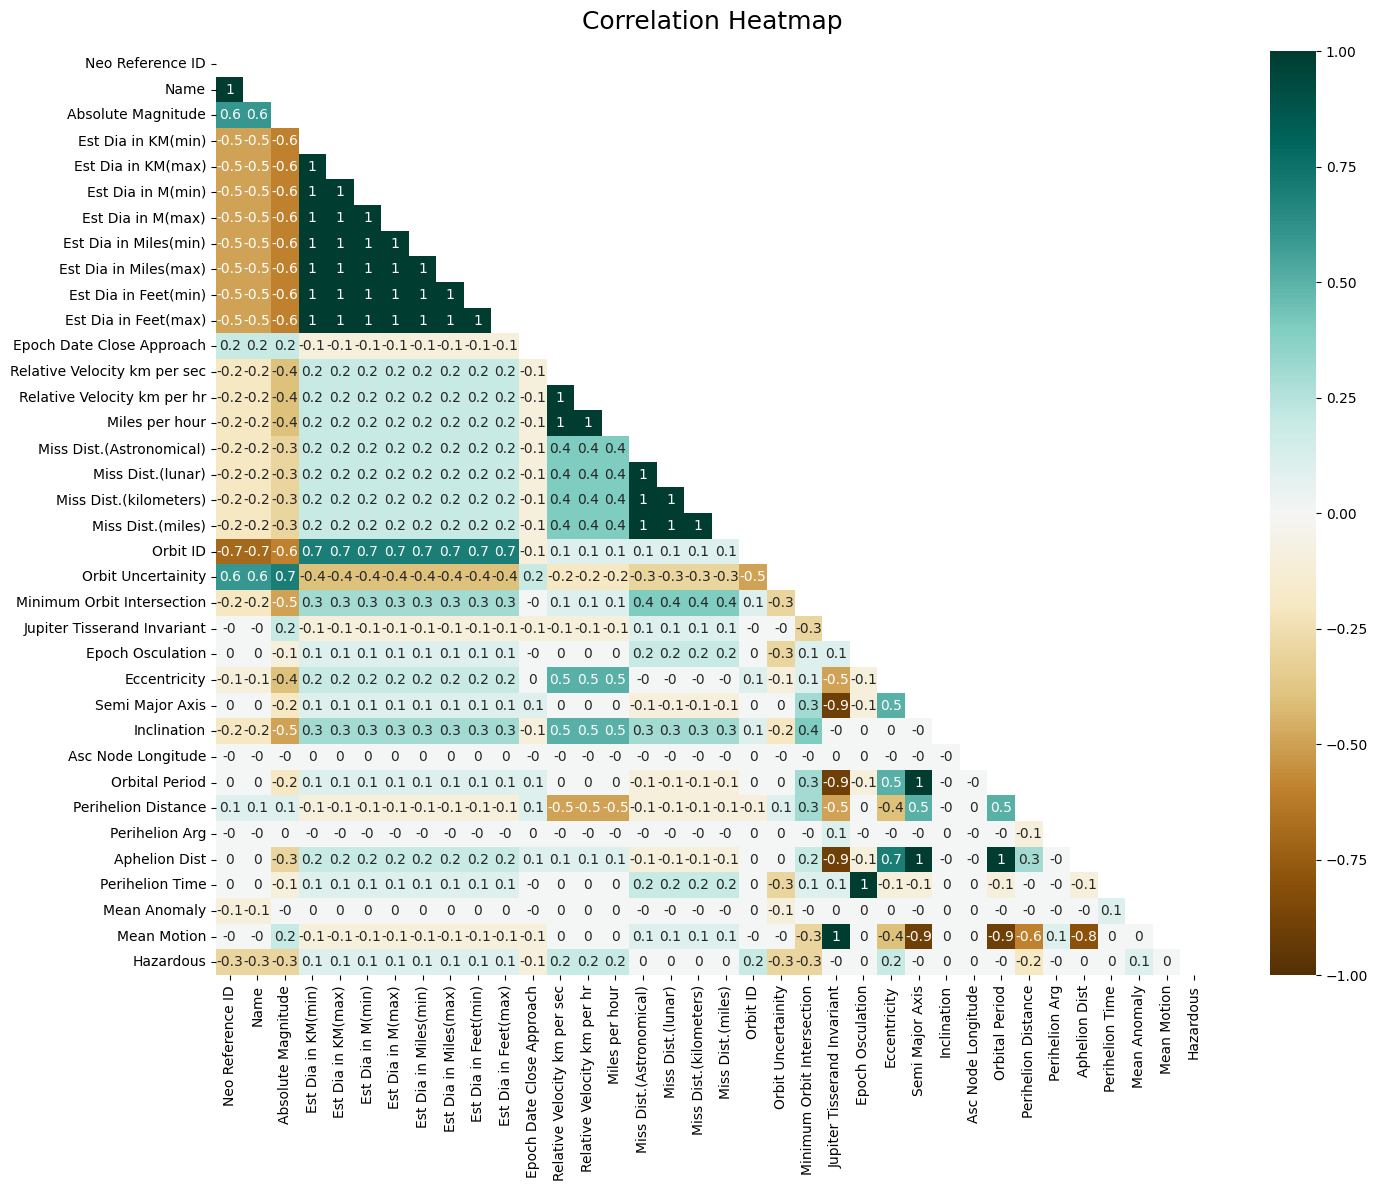

In [11]:
plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
heatmap = sns.heatmap(round(df.corr(),1), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

In [13]:
drop_cols= ['Est Dia in M(min)', 'Est Dia in M(max)','Est Dia in Miles(min)', 'Est Dia in Miles(max)','Est Dia in Feet(min)', 'Est Dia in Feet(max)','Relative Velocity km per hr', 'Miles per hour','Miss Dist.(lunar)','Miss Dist.(miles)','Miss Dist.(Astronomical)']
df.drop(labels=drop_cols, axis=1, inplace=True)

In [14]:
df.head()


,Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Epoch Date Close Approach,Relative Velocity km per sec,Miss Dist.(kilometers),Orbit ID,Orbit Uncertainity,...,Inclination,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Hazardous
0,3703080,3703080,21.6,0.127220,0.284472,788947200000,6.115834,62753692.0,17,5,...,6.025981,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,True
1,3723955,3723955,21.3,0.146068,0.326618,788947200000,18.113985,57298148.0,21,3,...,28.412996,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,False
2,2446862,2446862,20.3,0.231502,0.517654,789552000000,7.590711,7622911.5,22,0,...,4.237961,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,True
3,3092506,3092506,27.4,0.008801,0.019681,790156800000,11.173874,42683616.0,7,6,...,7.905894,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,False
4,3514799,3514799,21.6,0.127220,0.284472,790156800000,9.840831,61010824.0,25,1,...,16.793382,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,True


In [15]:
df.nunique()


Neo Reference ID                3692
Name                            3692
Absolute Magnitude               269
Est Dia in KM(min)               269
Est Dia in KM(max)               269
Epoch Date Close Approach        777
Relative Velocity km per sec    4687
Miss Dist.(kilometers)          4661
Orbit ID                         188
Orbit Uncertainity                10
Minimum Orbit Intersection      3678
Jupiter Tisserand Invariant     2495
Epoch Osculation                 429
Eccentricity                    3692
Semi Major Axis                 3692
Inclination                     3692
Asc Node Longitude              3692
Orbital Period                  3692
Perihelion Distance             3692
Perihelion Arg                  3692
Aphelion Dist                   3692
Perihelion Time                 3692
Mean Anomaly                    3692
Mean Motion                     3692
Hazardous                          2
dtype: int64

In [17]:
df.drop(['Neo Reference ID','Name'], axis=1, inplace=True)


In [18]:
df.columns=df.columns.str.replace(' ', '_')
df.head()

,Absolute_Magnitude,Est_Dia_in_KM(min),Est_Dia_in_KM(max),Epoch_Date_Close_Approach,Relative_Velocity_km_per_sec,Miss_Dist.(kilometers),Orbit_ID,Orbit_Uncertainity,Minimum_Orbit_Intersection,Jupiter_Tisserand_Invariant,...,Inclination,Asc_Node_Longitude,Orbital_Period,Perihelion_Distance,Perihelion_Arg,Aphelion_Dist,Perihelion_Time,Mean_Anomaly,Mean_Motion,Hazardous
0,21.6,0.127220,0.284472,788947200000,6.115834,62753692.0,17,5,0.025282,4.634,...,6.025981,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,True
1,21.3,0.146068,0.326618,788947200000,18.113985,57298148.0,21,3,0.186935,5.457,...,28.412996,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,False
2,20.3,0.231502,0.517654,789552000000,7.590711,7622911.5,22,0,0.043058,4.557,...,4.237961,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,True
3,27.4,0.008801,0.019681,790156800000,11.173874,42683616.0,7,6,0.005512,5.093,...,7.905894,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,False
4,21.6,0.127220,0.284472,790156800000,9.840831,61010824.0,25,1,0.034798,5.154,...,16.793382,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,True


In [22]:
encoder = LabelBinarizer()

In [20]:
df["Hazardous"] = encoder.fit_transform(df["Hazardous"])

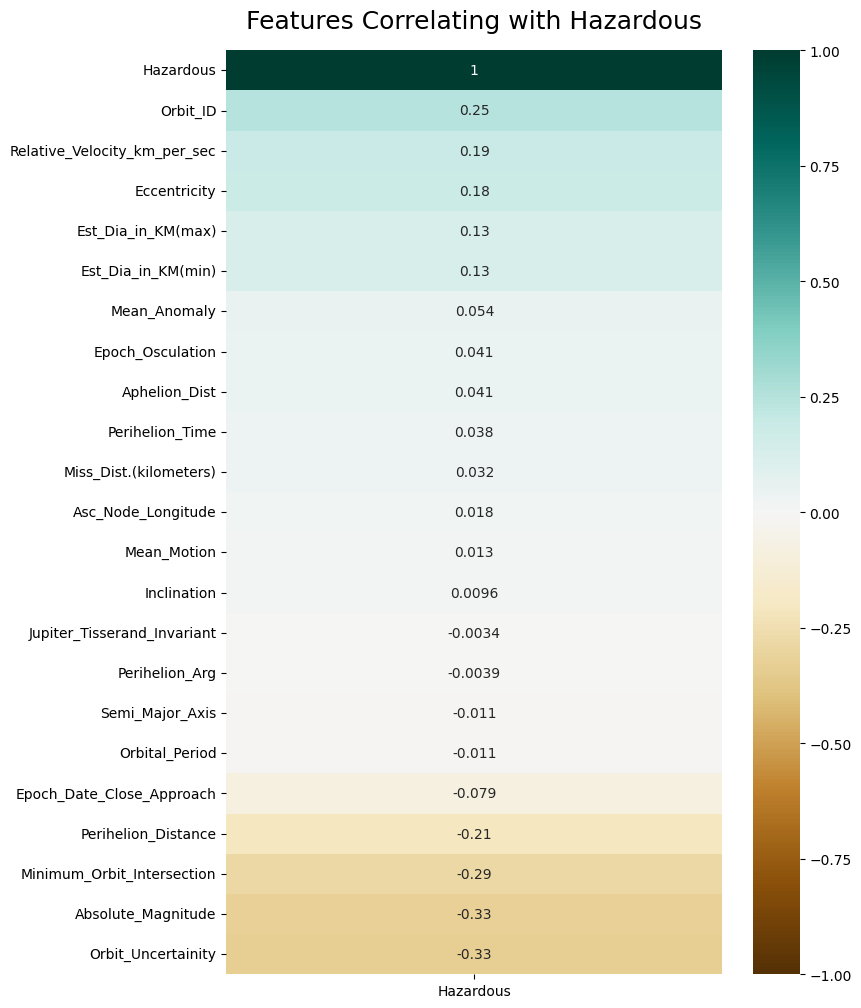

In [23]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['Hazardous']].sort_values(by='Hazardous', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Hazardous', fontdict={'fontsize':18}, pad=16);

In [24]:
df.Hazardous.value_counts()

Hazardous
0    3932
1     755
Name: count, dtype: int64

In [50]:
X = df.drop("Hazardous", axis=1)
y = df['Hazardous']

scaler = RobustScaler()
X_columns = X.columns
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=X_columns)

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size= 0.2, random_state=123)


xgb = XGBClassifier(use_label_encoder=False)
xgb_pred_train = xgb.fit(X_train, y_train).predict(X_train)
xgb_pred_test = xgb.predict(X_test)

xgb_prob_pred = xgb.predict_proba(X_test)

xgb_pred_test

array([1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,

In [26]:
xgb_prob_pred

array([[1.4343858e-03, 9.9856561e-01],
       [9.9948531e-01, 5.1471218e-04],
       [9.9994934e-01, 5.0655919e-05],
       ...,
       [9.9977016e-01, 2.2985051e-04],
       [9.9977130e-01, 2.2869369e-04],
       [9.9992698e-01, 7.3028925e-05]], dtype=float32)

In [27]:
print(classification_report(xgb_pred_train, y_train))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3145
           1       1.00      1.00      1.00       604

    accuracy                           1.00      3749
   macro avg       1.00      1.00      1.00      3749
weighted avg       1.00      1.00      1.00      3749



In [28]:
print(classification_report(xgb_pred_test, y_test))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       785
           1       1.00      0.99      0.99       153

    accuracy                           1.00       938
   macro avg       1.00      0.99      1.00       938
weighted avg       1.00      1.00      1.00       938



In [62]:
opt = BayesSearchCV(
    xgb,
    {
            'learning_rate' : Real(0.01, 1, prior="uniform"),
            'n_estimators' : Integer(1, 10, 'uniform'),
            'max_depth' : Integer(1, 10, 'uniform'),
    },
     n_iter=32,
     random_state=0
     
    )                    

In [63]:
opt.fit(X_train, y_train)
bopt_pred = opt.predict(X_test)

AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [67]:
print(accuracy_score(y_test, bopt_pred))

NameError: name 'bopt_pred' is not defined

In [72]:
str = "Welcome"
print(str[:6], "Participants")

Welcom Participants


In [64]:
rfc_param = {'n_estimators' : [1, 2, 3, 5, 6, 7, 8, 9,10],
             'learning_rate' : [0.001, 0.01, 0.3, 0.5],
             'max_depth' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
             }

In [65]:
random = RandomizedSearchCV(estimator = xgb,
                            param_distributions= rfc_param , 
                            scoring= 'recall',
                            cv=5,
                            n_iter=10,
                            return_train_score=True,
                            random_state=123,
                            verbose=0)

In [68]:
random_fit = random.fit(X_train, y_train)
print("best parameters are: ")
print(random_fit.best_params_)

best parameters are: 
{'n_estimators': 10, 'max_depth': 5, 'learning_rate': 0.01}


In [69]:
rand_opt = XGBClassifier(use_label_encoder= False, n_estimators = 1, max_depth = 9, learning_rate = 0.5)

In [70]:
print(classification_report(y_test, rand_opt.fit(X_train, y_train).predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       787
           1       0.98      0.99      0.98       151

    accuracy                           0.99       938
   macro avg       0.99      0.99      0.99       938
weighted avg       0.99      0.99      0.99       938

